In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets   
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from timeit import default_timer as timer

C:\ANACONDA\envs\pytorch_dl\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [60]:
class LeNET(nn.Module):
  def __init__(self, in_channels=1,num_classes=10):
    super(LeNET, self).__init__()
    self.in_channels = in_channels
    self.num_classes = num_classes
    self.relu = nn.ReLU()
    self.pool = nn.AvgPool2d(kernel_size = (2,2), stride=(2,2))
    self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = 6, kernel_size = (5,5), stride = (1,1), padding = (2,2))
    self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = (5,5), stride = (1,1), padding = (0,0))
    self.conv3 = nn.Conv2d(in_channels = 16, out_channels =120, kernel_size = (5,5), stride = (1,1), padding = (0,0))
    self.linear1 = nn.Linear(120, 84)
    self.linear2 = nn.Linear(84,num_classes)

  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.pool(x)
    x = self.relu(self.conv2(x))
    x = self.pool(x)
    x = self.relu(self.conv3(x))# num_examples x 120 x 1 x 1 -- > num_examples x 120
    x = x.reshape(x.shape[0], -1)
    x = self.relu(self.linear1(x))
    x = self.linear2(x)
    return x 

In [3]:
x = torch.randn(64, 1, 28, 28)
model = LeNET()
print(model(x).shape)

torch.Size([64, 10])


In [4]:
#Setup train data
train_data = datasets.MNIST(root="data",
                                   train=True,
                                   download=True,
                                   transform=transforms.ToTensor())

test_data = datasets.MNIST(root="data",
                                   train=False,
                                   download=True,
                                   transform=transforms.ToTensor())

In [5]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [6]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

Image Shape: torch.Size([1, 28, 28])


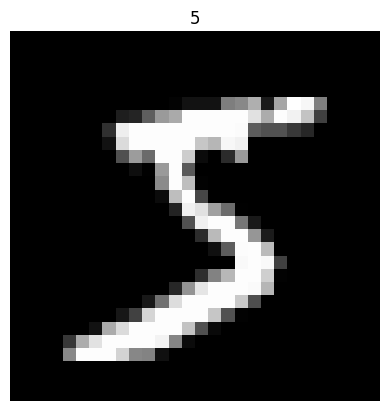

In [7]:
#Visualising the data
#understanding input and output shape
image, label = train_data[0]
print(f"Image Shape: {image.shape}")
plt.imshow(image.squeeze(), cmap="gray")
plt.title(label);
plt.axis(False);

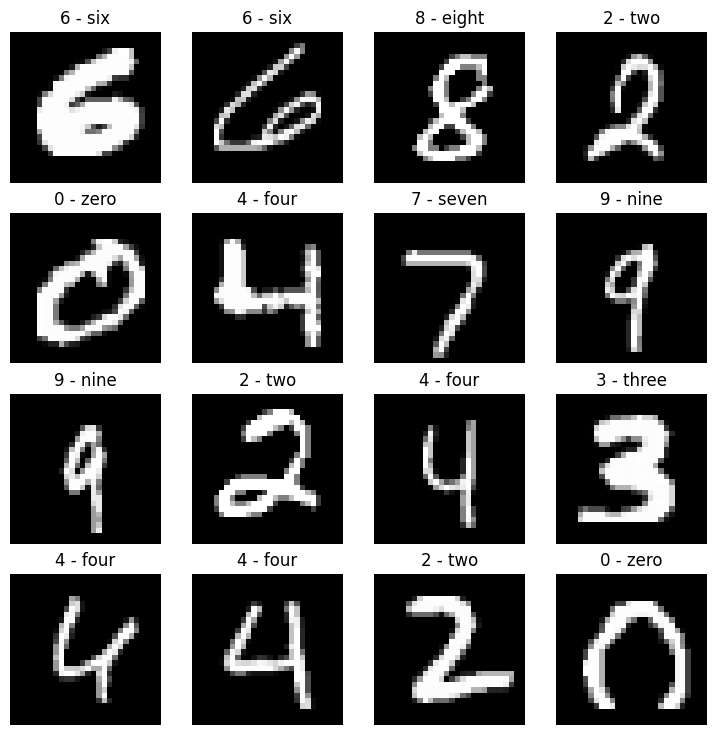

In [8]:
#Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

In [9]:
#Prepare Dataloader that prepares our data into python iterable
#We turn our data into mini batches since it is more computationally efficient
from torch.utils.data import DataLoader

#Setup the batch size hyperparameter
BATCH_SIZE = 128
device = "cuda" if torch.cuda.is_available() else "cpu"

#Turn datasets into iterables(batches)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
model_LENET_0 = LeNET().to(device)

In [11]:
def print_train_time(start:float,
                     end:float,
                     device:torch.device=None):
  total_time = end-start
  print(f"Train time on {device} : {total_time:.3f} seconds")
  return total_time

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_LENET_0.parameters(), lr=0.03)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [13]:
#Functionizing training and evaluation/testing loops
#We create a function for training loop - train_step()
#testing loop - test_step()

def train_step(model:torch.nn.Module, data_loader:torch.utils.data.DataLoader,loss_fn:torch.nn.Module,optimizer:torch.optim.Optimizer,accuracy_fn,device:torch.device=device):
  #Performs training step on model trying to learn from data loader
  train_loss, train_acc = 0, 0
  #Put model in training mode
  model.train()
  #Add a loop through the training batches 
  for batch, (X,y) in enumerate(data_loader):#Enumerate helps keeping track of batches
    #Put data on target device
    X,y = X.to(device), y.to(device)
    #forward pass
    y_pred = model(X)
    #loss and accuracy
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    #Optimizer zero grad
    optimizer.zero_grad()
    #Loss backward
    loss.backward()
    #Step
    optimizer.step()

  #Adjust the training loss so that it gives us the loss per epoch an not per batch
  #Divide total train loss by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train Loss: {train_loss:.5f}, Train acc: {train_acc:.2f}%")

In [14]:
def test_step(model:torch.nn.Module, data_loader:torch.utils.data.DataLoader,loss_fn:torch.nn.Module,optimizer:torch.optim.Optimizer,accuracy_fn,device:torch.device=device):
  #Performs training step on model trying to learn from data loader
  test_loss, test_acc = 0, 0
  #Put model in training mode
  model.eval()
  #Add a loop through the training batches 
  with torch.inference_mode():
    for X,y in data_loader:#Enumerate helps keeping track of batches
      #Put data on target device
      X,y = X.to(device), y.to(device)
      #forward pass
      test_pred = model(X)
      #loss and accuracy
      loss = loss_fn(test_pred, y)
      test_loss += loss
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    #Adjust the training loss so that it gives us the loss per epoch an not per batch
    #Divide total train loss by length of train dataloader
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

In [15]:
torch.manual_seed(42)

#Measure time
train_time_start_on_gpu = timer()

#Set epochs
epochs=5

#Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} ----")
  train_step(model=model_LENET_0, data_loader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
  test_step(model=model_LENET_0,data_loader=test_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 ----
Train Loss: 2.29945, Train acc: 11.11%


 20%|██        | 1/5 [00:21<01:26, 21.52s/it]

Test Loss: 2.28916, Test acc: 11.36%
Epoch: 1 ----
Train Loss: 1.41167, Train acc: 56.71%


 40%|████      | 2/5 [00:37<00:54, 18.30s/it]

Test Loss: 0.43234, Test acc: 86.80%
Epoch: 2 ----
Train Loss: 0.36371, Train acc: 88.75%


 60%|██████    | 3/5 [00:53<00:34, 17.40s/it]

Test Loss: 0.27337, Test acc: 91.55%
Epoch: 3 ----
Train Loss: 0.25310, Train acc: 92.22%


 80%|████████  | 4/5 [01:09<00:16, 16.83s/it]

Test Loss: 0.20631, Test acc: 94.09%
Epoch: 4 ----
Train Loss: 0.20101, Train acc: 93.84%


100%|██████████| 5/5 [01:25<00:00, 17.16s/it]

Test Loss: 0.16602, Test acc: 94.92%
Train time on cuda : 85.782 seconds


In [16]:
#Now we save the model
from pathlib import Path
#Create the model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
#Create the model save path
MODEL_NAME = "01_LENET_MNIST.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

In [17]:
#Saving the model
torch.save(obj=model_LENET_0.state_dict(),
           f=MODEL_SAVE_PATH)
print(f'Saved at {MODEL_SAVE_PATH}')

Saved at models\01_LENET_MNIST.pth


In [18]:
#Loading the model
#Create a new instance of the model and update the parameters
model_LENET_MNIST = LeNET().to(device)
model_LENET_MNIST.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [19]:
def eval_model(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device=device):
  loss,acc = 0, 0
  #Returns a dictionary containing the results of the model predicting on data_loader
  model.eval()
  with torch.inference_mode():
    for X,y in tqdm(data_loader):
      X,y = X.to(device), y.to(device)
      #Make predictions
      y_pred = model(X)

      #Accumulate the loss and acc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                         y_pred=y_pred.argmax(dim=1))
    #Scale the loss and acc to find the average loss and acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name":model.__class__.__name__,
          "model_loss":loss.item(),
          "model_acc":acc}

In [20]:
#Get model results
model_LENET_MNIST_results = eval_model(
    model=model_LENET_MNIST,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_LENET_MNIST_results

100%|██████████| 79/79 [00:01<00:00, 49.70it/s] 


{'model_name': 'LeNET',
 'model_loss': 0.16601650416851044,
 'model_acc': 94.91693037974683}

Fashion MNIST


In [21]:
train_data = datasets.FashionMNIST(root="data",
                                   train=True,
                                   download=True,
                                   transform=transforms.ToTensor())

test_data = datasets.FashionMNIST(root="data",
                                   train=False,
                                   download=True,
                                   transform=transforms.ToTensor())

100%|██████████| 26421880/26421880 [00:03<00:00, 8056287.53it/s] 


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<?, ?it/s]


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:00<00:00, 11060539.62it/s]


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



In [22]:
class_names = train_data.classes
class_to_idx = train_data.class_to_idx
class_to_idx, class_names

({'T-shirt/top': 0,
  'Trouser': 1,
  'Pullover': 2,
  'Dress': 3,
  'Coat': 4,
  'Sandal': 5,
  'Shirt': 6,
  'Sneaker': 7,
  'Bag': 8,
  'Ankle boot': 9},
 ['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'])

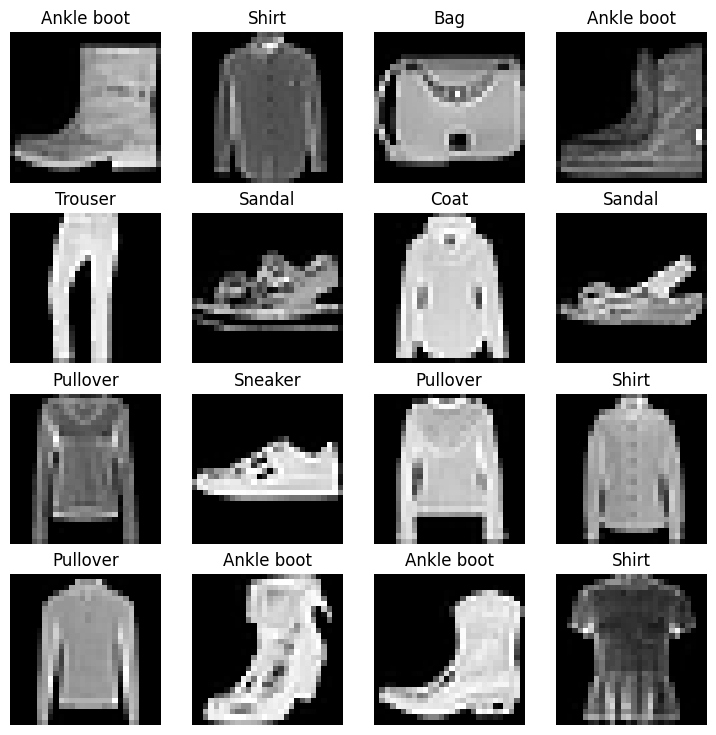

In [23]:
#Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

In [24]:
#Prepare Dataloader that prepares our data into python iterable
#We turn our data into mini batches since it is more computationally efficient
from torch.utils.data import DataLoader

#Setup the batch size hyperparameter
BATCH_SIZE = 32

#Turn datasets into iterables(batches)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [25]:
model_LENET_1 = LeNET().to(device)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [26]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_LENET_1.parameters(), lr=0.03)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [27]:
torch.manual_seed(42)

#Measure time
train_time_start_on_gpu = timer()

#Set epochs
epochs=5

#Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} ----")
  train_step(model=model_LENET_1, data_loader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
  test_step(model=model_LENET_1,data_loader=test_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 ----
Train Loss: 1.10729, Train acc: 58.13%


 20%|██        | 1/5 [00:27<01:49, 27.49s/it]

Test Loss: 0.68621, Test acc: 73.89%
Epoch: 1 ----
Train Loss: 0.54838, Train acc: 79.05%


 40%|████      | 2/5 [01:11<01:50, 36.95s/it]

Test Loss: 0.52394, Test acc: 79.70%
Epoch: 2 ----
Train Loss: 0.46145, Train acc: 82.81%


 60%|██████    | 3/5 [01:47<01:13, 36.80s/it]

Test Loss: 0.44731, Test acc: 83.14%
Epoch: 3 ----
Train Loss: 0.41738, Train acc: 84.39%


 80%|████████  | 4/5 [02:22<00:36, 36.09s/it]

Test Loss: 0.42182, Test acc: 84.50%
Epoch: 4 ----
Train Loss: 0.38540, Train acc: 85.76%


100%|██████████| 5/5 [02:53<00:00, 34.79s/it]

Test Loss: 0.41470, Test acc: 84.94%
Train time on cuda : 173.944 seconds


In [28]:
#Now we save the model
from pathlib import Path
#Create the model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
#Create the model save path
MODEL_NAME = "02_LENET_FashionMNIST.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

In [29]:
#Saving the model
torch.save(obj=model_LENET_1.state_dict(),
           f=MODEL_SAVE_PATH)
print(f'Saved at {MODEL_SAVE_PATH}')

Saved at models\02_LENET_FashionMNIST.pth


In [30]:
#Loading the model
#Create a new instance of the model and update the parameters
model_LENET_FashionMNIST = LeNET().to(device)
model_LENET_FashionMNIST.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [31]:
#Get model results
model_LENET_FashionMNIST_results = eval_model(
    model=model_LENET_FashionMNIST,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_LENET_FashionMNIST_results

100%|██████████| 313/313 [00:02<00:00, 152.33it/s]


{'model_name': 'LeNET',
 'model_loss': 0.4146980047225952,
 'model_acc': 84.94408945686901}

CIFAR 10


In [32]:
train_data = datasets.CIFAR10(root="data",
                                   train=True,
                                   download=True,
                                   transform=transforms.Compose([transforms.Resize(size=(28,28)),transforms.ToTensor()]))

test_data = datasets.CIFAR10(root="data",
                                   train=False,
                                   download=True,
                                   transform=transforms.Compose([transforms.Resize(size=(28,28)),transforms.ToTensor()]))

100%|██████████| 170498071/170498071 [00:25<00:00, 6613940.49it/s]


Extracting data\cifar-10-python.tar.gz to data
Files already downloaded and verified


In [33]:
class_names = train_data.classes
class_to_idx = train_data.class_to_idx
class_to_idx, class_names

({'airplane': 0,
  'automobile': 1,
  'bird': 2,
  'cat': 3,
  'deer': 4,
  'dog': 5,
  'frog': 6,
  'horse': 7,
  'ship': 8,
  'truck': 9},
 ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'])

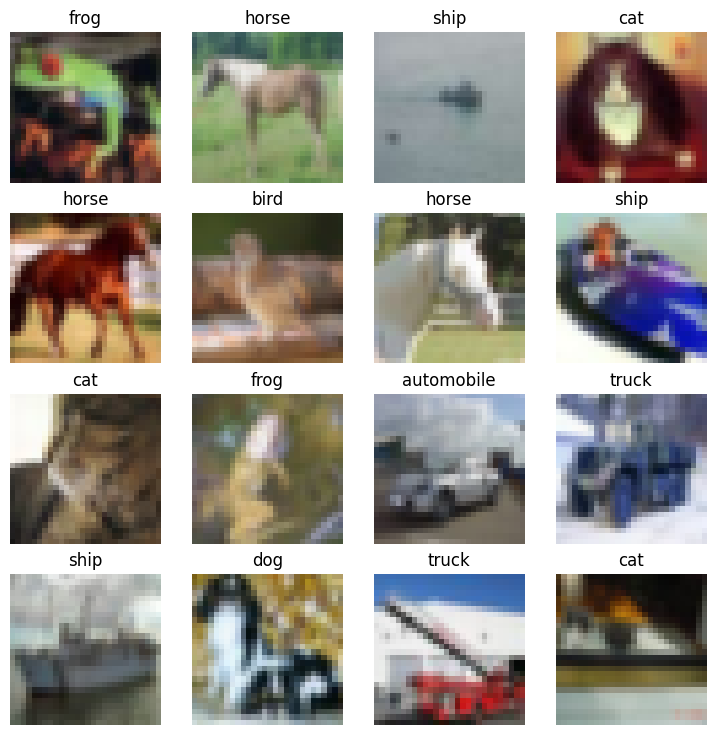

In [34]:
#Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.permute(1, 2, 0))#(c,h,w) moves channel to the back in accordance to the matplotlib format
  plt.title(class_names[label])
  plt.axis(False)

In [35]:
#Prepare Dataloader that prepares our data into python iterable
#We turn our data into mini batches since it is more computationally efficient
from torch.utils.data import DataLoader

#Setup the batch size hyperparameter
BATCH_SIZE = 32
device = "cuda" if torch.cuda.is_available() else "cpu"

#Turn datasets into iterables(batches)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [36]:
model_LENET_2 = LeNET(in_channels=3).to(device)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [37]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_LENET_2.parameters(), lr=0.03)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [38]:
torch.manual_seed(42)

#Measure time
train_time_start_on_gpu = timer()

#Set epochs
epochs=5

#Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} ----")
  train_step(model=model_LENET_2, data_loader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
  test_step(model=model_LENET_2,data_loader=test_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 ----
Train Loss: 2.30287, Train acc: 9.93%


 20%|██        | 1/5 [00:33<02:14, 33.57s/it]

Test Loss: 2.30112, Test acc: 13.06%
Epoch: 1 ----
Train Loss: 2.07427, Train acc: 23.20%


 40%|████      | 2/5 [01:07<01:41, 33.88s/it]

Test Loss: 1.86053, Test acc: 33.29%
Epoch: 2 ----
Train Loss: 1.76641, Train acc: 36.61%


 60%|██████    | 3/5 [01:44<01:10, 35.11s/it]

Test Loss: 1.64567, Test acc: 40.10%
Epoch: 3 ----
Train Loss: 1.60198, Train acc: 42.66%


 80%|████████  | 4/5 [02:15<00:33, 33.51s/it]

Test Loss: 1.60386, Test acc: 42.37%
Epoch: 4 ----
Train Loss: 1.50309, Train acc: 46.09%


100%|██████████| 5/5 [02:42<00:00, 32.46s/it]

Test Loss: 1.55624, Test acc: 45.04%
Train time on cuda : 162.318 seconds


In [39]:
#Now we save the model
from pathlib import Path
#Create the model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
#Create the model save path
MODEL_NAME = "03_LENET_CIFAR10pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

In [40]:
#Saving the model
torch.save(obj=model_LENET_2.state_dict(),
           f=MODEL_SAVE_PATH)
print(f'Saved at {MODEL_SAVE_PATH}')

Saved at models\03_LENET_CIFAR10pth


In [41]:
#Loading the model
#Create a new instance of the model and update the parameters
model_LENET_CIFAR10 = LeNET(in_channels=3).to(device)
model_LENET_CIFAR10.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [42]:
#Get model results
model_LENET_CIFAR10_results = eval_model(
    model=model_LENET_CIFAR10,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_LENET_CIFAR10_results

100%|██████████| 313/313 [00:03<00:00, 93.47it/s] 


{'model_name': 'LeNET',
 'model_loss': 1.5562423467636108,
 'model_acc': 45.0379392971246}

CIFAR100

In [43]:
train_data = datasets.CIFAR100(root="data",
                                   train=True,
                                   download=True,
                                   transform=transforms.Compose([transforms.Resize(size=(28,28)),transforms.ToTensor()]))

test_data = datasets.CIFAR100(root="data",
                                   train=False,
                                   download=True,
                                   transform=transforms.Compose([transforms.Resize(size=(28,28)),transforms.ToTensor()]))

100%|██████████| 169001437/169001437 [00:21<00:00, 7787718.00it/s] 


Extracting data\cifar-100-python.tar.gz to data
Files already downloaded and verified


In [44]:
class_names = train_data.classes
class_to_idx = train_data.class_to_idx
class_to_idx, class_names

({'apple': 0,
  'aquarium_fish': 1,
  'baby': 2,
  'bear': 3,
  'beaver': 4,
  'bed': 5,
  'bee': 6,
  'beetle': 7,
  'bicycle': 8,
  'bottle': 9,
  'bowl': 10,
  'boy': 11,
  'bridge': 12,
  'bus': 13,
  'butterfly': 14,
  'camel': 15,
  'can': 16,
  'castle': 17,
  'caterpillar': 18,
  'cattle': 19,
  'chair': 20,
  'chimpanzee': 21,
  'clock': 22,
  'cloud': 23,
  'cockroach': 24,
  'couch': 25,
  'crab': 26,
  'crocodile': 27,
  'cup': 28,
  'dinosaur': 29,
  'dolphin': 30,
  'elephant': 31,
  'flatfish': 32,
  'forest': 33,
  'fox': 34,
  'girl': 35,
  'hamster': 36,
  'house': 37,
  'kangaroo': 38,
  'keyboard': 39,
  'lamp': 40,
  'lawn_mower': 41,
  'leopard': 42,
  'lion': 43,
  'lizard': 44,
  'lobster': 45,
  'man': 46,
  'maple_tree': 47,
  'motorcycle': 48,
  'mountain': 49,
  'mouse': 50,
  'mushroom': 51,
  'oak_tree': 52,
  'orange': 53,
  'orchid': 54,
  'otter': 55,
  'palm_tree': 56,
  'pear': 57,
  'pickup_truck': 58,
  'pine_tree': 59,
  'plain': 60,
  'plate': 61,

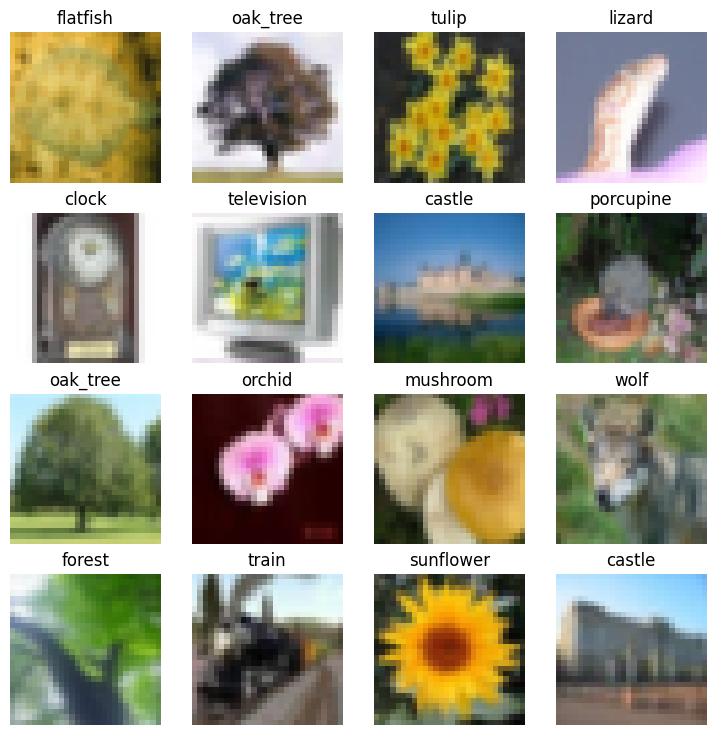

In [45]:
#Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.permute(1, 2, 0))#(c,h,w) moves channel to the back in accordance to the matplotlib format
  plt.title(class_names[label])
  plt.axis(False)

In [46]:
#Prepare Dataloader that prepares our data into python iterable
#We turn our data into mini batches since it is more computationally efficient
from torch.utils.data import DataLoader

#Setup the batch size hyperparameter
BATCH_SIZE = 32
device = "cuda" if torch.cuda.is_available() else "cpu"

#Turn datasets into iterables(batches)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [62]:
device = "cpu"
model_LENET_3 = LeNET(in_channels=3, num_classes=100).to(device)
device

'cpu'

In [63]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_LENET_3.parameters(), lr=0.03)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [64]:
#Measure time
train_time_start_on_gpu = timer()

#Set epochs
epochs=5

#Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} ----")
  train_step(model=model_LENET_3, data_loader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
  test_step(model=model_LENET_3,data_loader=test_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 ----
Train Loss: 4.57983, Train acc: 1.27%


 20%|██        | 1/5 [00:14<00:57, 14.36s/it]

Test Loss: 4.42119, Test acc: 2.62%
Epoch: 1 ----
Train Loss: 4.14559, Train acc: 5.98%


 40%|████      | 2/5 [00:28<00:42, 14.19s/it]

Test Loss: 4.06841, Test acc: 7.61%
Epoch: 2 ----
Train Loss: 3.90043, Train acc: 9.82%


 60%|██████    | 3/5 [00:42<00:28, 14.20s/it]

Test Loss: 3.83636, Test acc: 11.64%
Epoch: 3 ----
Train Loss: 3.74457, Train acc: 12.75%


 80%|████████  | 4/5 [00:56<00:14, 14.04s/it]

Test Loss: 3.72374, Test acc: 13.15%
Epoch: 4 ----
Train Loss: 3.61590, Train acc: 14.77%


100%|██████████| 5/5 [01:10<00:00, 14.04s/it]

Test Loss: 3.65466, Test acc: 14.83%
Train time on cpu : 70.207 seconds


In [65]:
#Now we save the model
from pathlib import Path
#Create the model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
#Create the model save path
MODEL_NAME = "04_LENET_CIFAR100pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

In [66]:
#Saving the model
torch.save(obj=model_LENET_3.state_dict(),
           f=MODEL_SAVE_PATH)
print(f'Saved at {MODEL_SAVE_PATH}')

Saved at models\04_LENET_CIFAR100pth


In [70]:
#Loading the model
#Create a new instance of the model and update the parameters
model_LENET_CIFAR100 = LeNET(in_channels=3, num_classes=100).to(device)
model_LENET_CIFAR100.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [71]:
#Get model results
model_LENET_CIFAR100_results = eval_model(
    model=model_LENET_CIFAR100,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_LENET_CIFAR100_results

100%|██████████| 313/313 [00:01<00:00, 175.86it/s]


{'model_name': 'LeNET',
 'model_loss': 3.654658317565918,
 'model_acc': 14.826277955271566}

In [72]:
import pandas as pd
compare_results = pd.DataFrame([model_LENET_MNIST_results,
                                model_LENET_FashionMNIST_results,
                                model_LENET_CIFAR10_results,
                                model_LENET_CIFAR100_results])
compare_results

,model_name,model_loss,model_acc
0,LeNET,0.166017,94.916930
1,LeNET,0.414698,84.944089
2,LeNET,1.556242,45.037939
3,LeNET,3.654658,14.826278


In [75]:
#In the chart below the models are as follows :

#LeNET on MNIST Dataset

#LeNET on FashionMNIST Dataset

#LeNET on CIFAR 10 Dataset

#LeNET on CIFAR 100 Datase

Text(0, 0.5, 'Model')

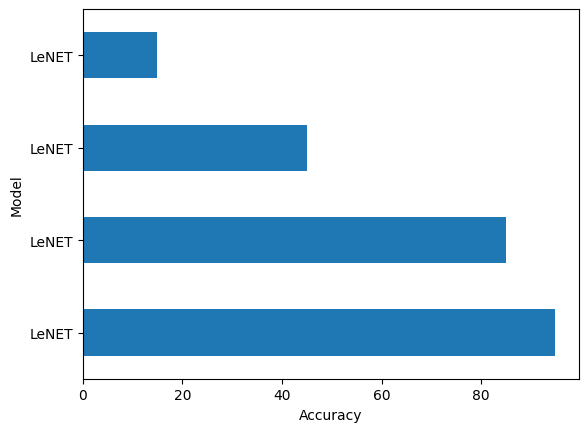

In [73]:
#Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("Accuracy")
plt.ylabel("Model")